# Generate corner plot for mass sampling experiment

This notebook generates the final corner plot for displaying posterior distributions of lens model parameters (+ optionally source grid offsets parameters). It reads in backup files generated with the `mock_source_mass_sampling.py` script, that runs an MCMC through the Lenstronomy.

__Author__ : Aymeric Galan

__Created__ : 6/11/20

__Updated__ : 7/12/20

In [1]:
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

__author__ = 'aymgal'

import matplotlib.pyplot as plt
plt.rc('image', interpolation='none', origin='lower')
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

import os
import copy
import glob
import scipy
import pickle as pkl
import numpy as np
from matplotlib.colors import LogNorm
import time

from tqdm import tqdm

from lenstronomy.Sampling.parameters import Param
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.Numerics.grid import RegularGrid
from lenstronomy.Plots import lens_plot, chain_plot
from lenstronomy.Util import mask_util
from lenstronomy.Util import image_util
from lenstronomy.Util import param_util
import lenstronomy.Util.util as lenstro_util

from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from slitronomy.Util.plot_util import nice_colorbar, nice_colorbar_residuals, log_cmap
from slitronomy.Util import metrics_util

import sys
sys.path.insert(0, '..')
import fixed_param
import mass_util
import source_util
import psf_util

SEED = 18

%matplotlib inline

#### Choice of colormaps for image plots

In [2]:
cmap_default = plt.get_cmap('viridis')
cmap_residuals = plt.get_cmap('RdBu_r')
cmap_flux = copy.copy(plt.get_cmap('cubehelix'))
cmap_flux.set_bad(color='black', alpha=1)
cmap_flux_with_neg = copy.copy(plt.get_cmap('cubehelix'))
cmap_flux_with_neg.set_bad(color='#222222', alpha=1)  # emphasize negative pixels when in log scale

## Load samples from backup files

In [3]:
source_grid_offset = True

if not source_grid_offset:
    model_name_list = [
        ('results_shear_g1g2/backups_ss2', r"$r_{\rm pix}=2$"),
        ('results_shear_g1g2/backups_ss3', r"$r_{\rm pix}=3$"),
        ('results_shear_g1g2/backups_ss4', r"$r_{\rm pix}=4$"),
        ('results_shear_g1g2/backups_ss5', r"$r_{\rm pix}=5$"),
    ]
else:
    model_name_list = [
        ('results_with_offset/backups_ss2', r"$r_{\rm pix}=2$"),
        ('results_with_offset/backups_ss3', r"$r_{\rm pix}=3$"),
        ('results_with_offset/backups_ss4', r"$r_{\rm pix}=4$"),
        ('results_with_offset/backups_ss5', r"$r_{\rm pix}=5$"),
    ]

def load_samples(model_name, lens_model_list_simu):
    backup_path_glob = os.path.join(model_name, '*.pkl')
    backup_path = sorted(glob.glob(backup_path_glob))[0]
    data = pkl.load(open(backup_path, 'rb'))
    kwargs_result, chain_list, image_sim, image_model, source_model, _ = data
    sampler_type, samples, param_names, logL = chain_list[-1]
    # convert shear depeding on parametrization
    try:
        _ = param_names.index('gamma1_lens1')
    except:
        shear_is_ok = True
    else:
        shear_is_ok = False
    if not shear_is_ok and lens_model_list_simu[1] == 'SHEAR_GAMMA_PSI':
        g1_index, g2_index = param_names.index('gamma1_lens1'), param_names.index('gamma2_lens1')
        gamma1_samples, gamma2_samples = samples[:, g1_index], samples[:, g2_index]
        psi_ext_samples, gamma_ext_samples = param_util.shear_cartesian2polar(gamma1_samples, gamma2_samples)
        samples[:, g1_index] = gamma_ext_samples
        samples[:, g2_index] = psi_ext_samples
        param_names[g1_index] = 'gamma_ext_lens1'
        param_names[g2_index] = 'psi_ext_lens1'
    # convert ellipticity parametrization of the SIE
    if lens_model_list_simu[0] == 'SIE':
        e1_index, e2_index = param_names.index('e1_lens0'), param_names.index('e2_lens0')
        e1_samples, e2_samples = samples[:, e1_index], samples[:, e2_index]
        phi_samples, q_samples = param_util.ellipticity2phi_q(e1_samples, e2_samples)
        samples[:, e1_index] = q_samples
        samples[:, e2_index] = phi_samples
        param_names[e1_index] = 'q_lens0'
        param_names[e2_index] = 'phi_lens0'
    return samples, param_names, logL

## Get truth values from simulation

### Load general settings

In [4]:
data_type = 'HST'

# super sampling of the source (only for generating true source image)
supersampling_factor_source = 3

# seeing specifics
psf_type = 'PIXEL'
psf_kernel = psf_util.get_HST_psf_kernel()

# observational, instrumentation and numerical settings
kwargs_simulation, kwargs_numerics_simulation = fixed_param.get_simulation_kwargs(data_type, psf_type, psf_kernel)

# number of side pixels in cutout
delta_pix = kwargs_simulation['pixel_scale']
num_pix = int(fixed_param.cutout_size / delta_pix)
num_pix_source = int(num_pix*supersampling_factor_source)  # (maximum) number of side pixels for source plane

# lens model properties
lens_model_list, kwargs_lens = mass_util.get_lens_model_macro(fixed_param.sigma_v)

# main source galaxy properties
ra_source, dec_source = fixed_param.ra_source, fixed_param.dec_source
mag_source = fixed_param.mag_source

# retrieve source parameters
source_model_list, kwargs_source = source_util.prepare_highres_source(ra_source, dec_source, 
                                                                      galaxy_name=fixed_param.galaxy_name, 
                                                                      magnitude=fixed_param.mag_source)

### Define the function that simulates image data

In [5]:
def simulate_image(lens_model_list, kwargs_lens, source_model_list, kwargs_source, noise_seed=None):
    # wrap up the model components
    kwargs_model_sim = {
        'lens_model_list': lens_model_list,
        'source_light_model_list': source_model_list,
        #'lens_light_model_list': lens_light_model_list,
    }
    lens_model_class = LensModel(lens_model_list=lens_model_list)
    source_model_class = LightModel(light_model_list=source_model_list)
    
    # instantiate the simulation class
    sim_class = SimAPI(num_pix, kwargs_simulation, kwargs_model_sim)

    # get the image model class
    imsim_class = sim_class.image_model_class(kwargs_numerics=kwargs_numerics_simulation)

    # get other useful classes
    data_class = sim_class.data_class
    psf_class = sim_class.psf_class

    if 'magnitude' in kwargs_source[0]:
        # convert magnitudes into internal amplitude units based on instrumental settings
        #print(kwargs_source[0]['magnitude'])
        _, kwargs_source, _ = sim_class.magnitude2amplitude(kwargs_source_mag=kwargs_source)
        #print(kwargs_source[0]['amp'])
        
    # simulate the noise-free image
    image_sim_no_noise = imsim_class.image(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None)

    # add realistic noise
    seed = SEED if noise_seed is None else noise_seed
    image_sim = image_sim_no_noise + sim_class.noise_for_model(model=image_sim_no_noise, seed=seed)

    # update the data class with the simulated image
    data_class.update_data(image_sim)

    # one can also get the source light at the data resolution
    source_sim_data_res = imsim_class.source_surface_brightness(kwargs_source, de_lensed=True, unconvolved=True)
    
    # extract coordinates properties for orientation and pixel to angle conversion
    ra_at_xy_0, dec_at_xy_0 = data_class.radec_at_xy_0
    transform_pix2angle = data_class.transform_pix2angle

    # from these properties, create grid objects for image plane and source plane
    image_grid = RegularGrid(num_pix, num_pix, transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
    source_grid = RegularGrid(num_pix, num_pix, transform_pix2angle, ra_at_xy_0, dec_at_xy_0, 
                              supersampling_factor=supersampling_factor_source)

    # extract 1D coordinates arrays for easy evaluation surface brightness profiles
    ra_grid_hd, dec_grid_hd = source_grid.coordinates_evaluate

    source_sim = source_model_class.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source)
    source_sim = lenstro_util.array2image(source_sim)

    # flux normalization of true source for proper comparison with pixel-based reconstruction
    source_sim_comp = source_sim * delta_pix**2
    
    class_list = (imsim_class, data_class, psf_class, lens_model_class, source_model_class)
    
    # get the lost of true values
    kwargs_model_truth = {
        'lens_model_list': lens_model_list,
        'source_light_model_list': ['SLIT_STARLETS'], # allows support for source_grid_offset in Param class
    }
    kwargs_fixed_lens = [{}, {'ra_0': 0, 'dec_0': 0}]
    kwargs_fixed_source = [{'n_scales': 1, 'n_pixels': 1, 'center_x': 0, 'center_y': 0, 'scale': 0}]
    kwargs_special = {'delta_x_source_grid': 0, 'delta_y_source_grid': 0} if source_grid_offset else {}
    param_class = Param(kwargs_model_truth, 
                        kwargs_fixed_source=kwargs_fixed_source, 
                        kwargs_fixed_lens=kwargs_fixed_lens,
                        source_grid_offset=source_grid_offset)
    truth_values = param_class.kwargs2args(kwargs_lens=kwargs_lens,
                                           kwargs_source=[{}],
                                           kwargs_special=kwargs_special)
    # convert ellipticity parametrization
    e1_index, e2_index = 1, 2
    e1_value, e2_value = truth_values[e1_index], truth_values[e2_index]
    phi_value, q_value = param_util.ellipticity2phi_q(e1_value, e2_value)
    truth_values[e1_index], truth_values[e2_index] = q_value, phi_value
    return class_list, kwargs_source, source_sim_comp, source_sim_data_res, truth_values
                         

### Simulate imaging data and visualise products

Just a check.

In [6]:
class_list, kwargs_source, source_sim_comp, source_sim_data_res, truth_values = simulate_image(lens_model_list, kwargs_lens, source_model_list, kwargs_source)
imsim_class, data_class, psf_class, _, _ = class_list
image_sim = data_class.data
print(truth_values)

[1.330841155341295, 0.8, 0.0, 0, 0, 0.03, 0.7853981633974483, 0, 0]


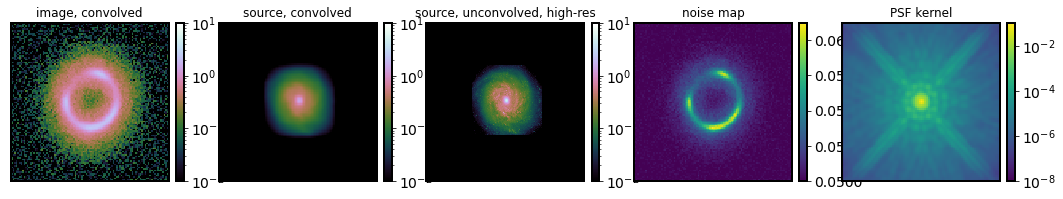

In [7]:
fig = plt.figure(figsize=(18, 4))

ax = plt.subplot(1, 5, 1)
ax.set_title("image, convolved")
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
im = ax.imshow(data_class.data, origin='lower', cmap=cmap_flux, norm=LogNorm(1e-2, 1e1))
nice_colorbar(im)

ax = plt.subplot(1, 5, 2)
ax.set_title("source, convolved")
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
source_sim_data_res_conv = imsim_class.source_surface_brightness(kwargs_source, de_lensed=True, unconvolved=False)
im = ax.imshow(source_sim_data_res_conv, origin='lower', cmap=cmap_flux, norm=LogNorm(1e-2, 1e1))
nice_colorbar(im)

ax = plt.subplot(1, 5, 3)
ax.set_title("source, unconvolved, high-res")
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
im = ax.imshow(source_sim_comp, origin='lower', cmap=cmap_flux, norm=LogNorm(1e-2, 1e1))
nice_colorbar(im)

ax = plt.subplot(1, 5, 4)
ax.set_title("noise map")
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
im = ax.imshow(np.sqrt(data_class.C_D), origin='lower', cmap=cmap_default)
nice_colorbar(im)

ax = plt.subplot(1, 5, 5)
ax.set_title("PSF kernel")
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
im = ax.imshow(psf_class.kernel_point_source, origin='lower', 
               cmap=cmap_default, norm=LogNorm(1e-8))
nice_colorbar(im)

plt.show()

## Corner plot

In [8]:
import corner
import seaborn as sns

def name2latex(name_list, plotting_engine='corner'):
    latex_list = []
    for name in name_list:
        if name in ['delta_x_source_grid', 'delta_y_source_grid']:
            name_no_num, num = name, None
        else:
            name_no_num, num = name[:-1], name[-1]
        if name_no_num == 'theta_E_lens':
            latex = r"$\theta_{\rm E}$"
        elif name_no_num == 'q_lens':
            latex = r"$q_{\rm m}$"
        elif name_no_num == 'phi_lens':
            latex = r"$\phi_{\rm m}$"
        #elif name_no_num == 'e1_lens':
        #    latex = r"$e_1$"
        #elif name_no_num == 'e2_lens':
        #    latex = r"$e_2$"
        elif name_no_num == 'center_x_lens':
            latex = r"$x_0$"
        elif name_no_num == 'center_y_lens':
            latex = r"$y_0$"
        elif name_no_num == 'gamma_lens':
            latex = r"$\gamma'$"
        elif name_no_num == 'gamma_ext_lens':
            latex = r"$\gamma_{\rm ext}$"
        elif name_no_num == 'psi_ext_lens':
            latex = r"$\phi_{\rm ext}$"
        #elif name_no_num == 'gamma1_lens':
        #    latex = r"$\gamma_1$"
        #elif name_no_num == 'gamma2_lens':
        #    latex = r"$\gamma_2$"
        elif name_no_num == 'delta_x_source_grid':
            latex = r"$\delta_{{\rm s},x}$"
        elif name_no_num == 'delta_y_source_grid':
            latex = r"$\delta_{{\rm s},y}$"
        else:
            raise ValueError("latex name for sampled variable '{}' is unknown".format(name_no_num))
        if plotting_engine == 'getdist':
            latex = latex[1:-1] # remove dollar signs
        latex_list.append(latex)
        latex = None
    return latex_list

def update_extents(extents, samples_corner, sigmas=3):
    N = samples_corner.shape[1]
    if extents is None:
        # initialization
        extents = [(-np.inf, np.inf)] * N
    # update extents
    for i in range(N):
        mean_i, std_i = np.mean(samples_corner[:, i]), np.std(samples_corner[:, i])
        if isinstance(extents[i], tuple):
            extents[i] = list(extents[i])  # because one cannot modify a tuple 
        old_i = extents[i]
        current_i = [mean_i - sigmas * std_i, mean_i + sigmas * std_i]
        if old_i == 1.:
            new_i = current_i
        elif np.isinf(old_i[0]) or np.isinf(old_i[1]):
            new_i = current_i
        else:
            if old_i[0] == 1.0:
                # e.g. when only ones in the sample, because it was filled with it due to missing samples initially
                new_i = [current_i[0], max(old_i[1], current_i[1])]
            elif old_i[1] == 1.0:
                # e.g. when only ones in the sample, because it was filled with it due to missing samples initially
                new_i = [min(old_i[0], current_i[0]), current_i[1]]
            else:
                new_i = [min(old_i[0], current_i[0]), max(old_i[1], current_i[1])]
        extents[i] = new_i
    # second pass to remove any remaining non-finite limits and prevent lower = upper bounds
    for i in range(N):
        extent_i = extents[i]
        if len(extent_i) == 2 and (not np.isfinite(extent_i[0]) or not np.isfinite(extent_i[1])):
            extents[i] = 1  # replace by the single valued default corner extent
        elif extent_i[0] == extent_i[1]:
            extents[i] = [extent_i[0]*0.9, extent_i[1]*1.1]  # take lower-10% and upper+10% 
    return extents

def add_values_indic_to_corner(fig, values, color='green', linewidth=1, linestyle='--', 
                               markersize=10, label=None, reverse=False):
    # Extract the axes
    ndim = len(values)
    axes = np.array(fig.axes).reshape((ndim, ndim))
    # Loop over the diagonal
    for i in range(ndim):
        if reverse:
            ax = axes[ndim - i - 1, ndim - i - 1]
        else:
            ax = axes[i, i]
        if values[i] is not None:
            ax.axvline(values[i], color=color, linewidth=linewidth, linestyle=linestyle, label=label)
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            if reverse:
                ax = axes[ndim - yi - 1, ndim - xi - 1]
            else:
                ax = axes[yi, xi]
            if values[xi] is not None:
                ax.axvline(values[xi], color=color, linewidth=linewidth, linestyle=linestyle)
            if values[yi] is not None:
                ax.axhline(values[yi], color=color, linewidth=linewidth, linestyle=linestyle)
            if values[xi] is not None and values[yi] is not None:
                ax.plot(values[xi], values[yi], color=color, marker='s', markersize=markersize)

def add_legend_to_corner(fig, fontsize=16, ax_idx=1):
    fig.axes[ax_idx].legend(*fig.axes[0].get_legend_handles_labels(), loc='upper left', fontsize=fontsize)

$r_{\rm pix}=2$ (45000, 9)
$r_{\rm pix}=3$ (45000, 9)
$r_{\rm pix}=4$ (45000, 9)
$r_{\rm pix}=5$ (45000, 9)
marginalised (180000, 9)


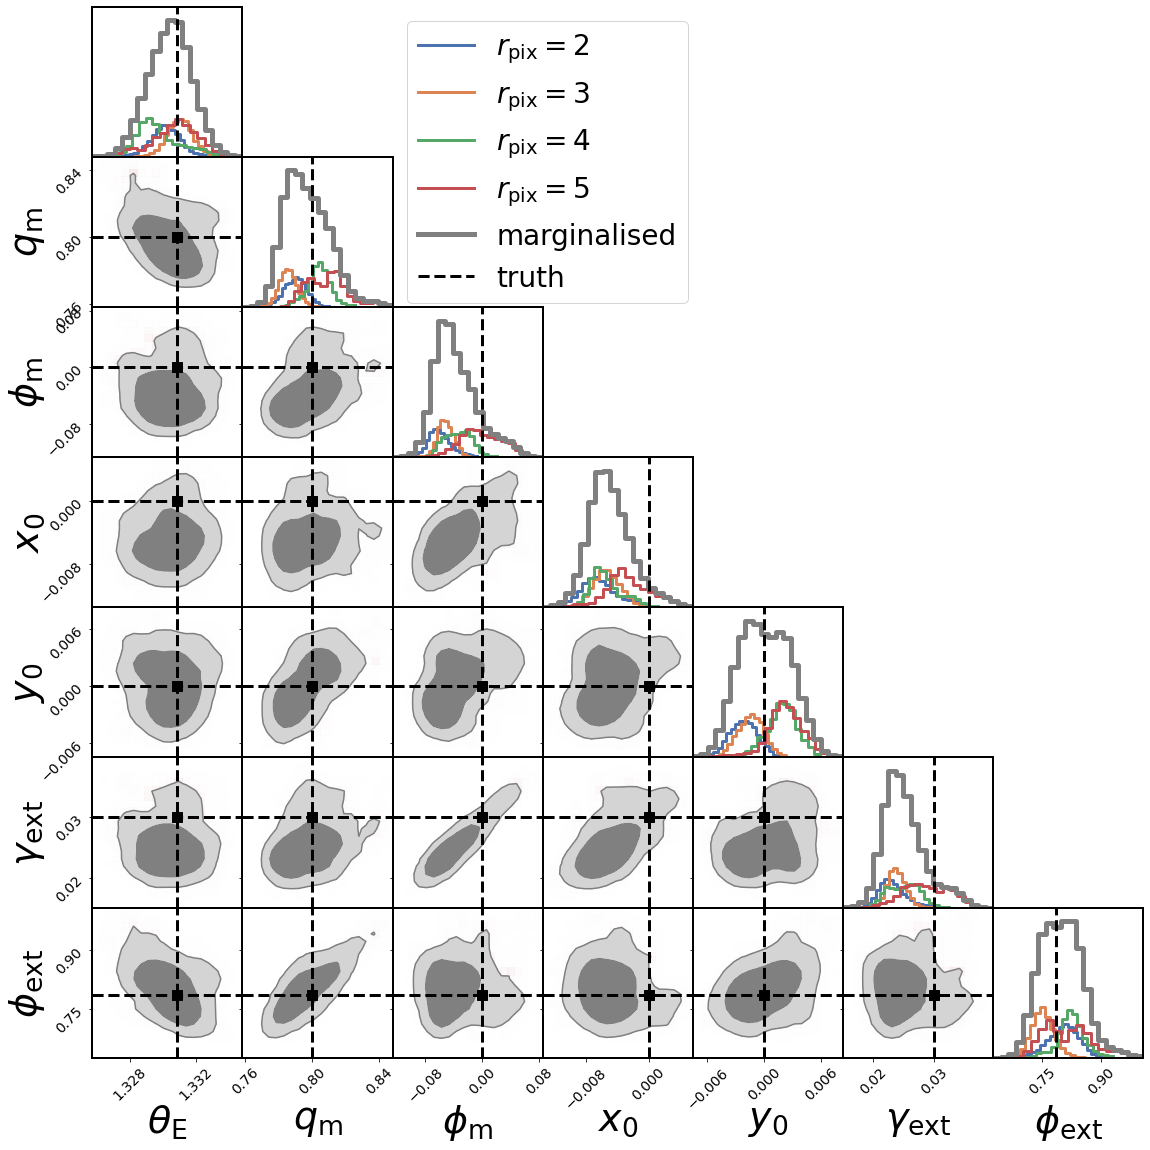

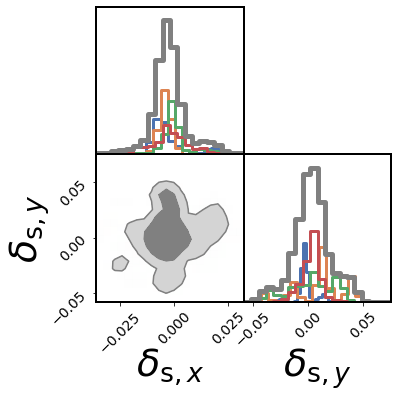

In [9]:
plot_individual_samples = True
plot_combined_samples = True
n_samples_final = None #10000

### corner settings ###
smoothing, smoothing_2d = 0.6, 0.6  # std deviation of gaussian kernel (0 < s < 1)
smoothing_c, smoothing_2d_c = 0.8, 0.8  # std deviation of gaussian kernel (0 < s < 1)
kwargs_corner = dict(
    max_n_ticks=3, show_titles=False,  # errorbarts too small so titles are not really useful
    smooth1d=smoothing, smooth=smoothing_2d,
    levels=(0.68, 0.95),
    plot_datapoints=False, 
    plot_contours=True, fill_contours=True, 
    #contourf_kwargs={'linewidths': 3},  # does not work
    hist_kwargs={'alpha': 1},
    title_kwargs={'fontsize': 19}, label_kwargs={'fontsize': 38}, 
)
color_palette = sns.color_palette("deep", len(model_name_list)).as_hex()
color_marg = 'gray'

fig = None
fig2 = None
extents, auto_update = None, True

# plot individual samples
samples_marg_equal = None
for i, model_name_tuple in enumerate(model_name_list):
    color = color_palette[i]
    model_name, model_short_name = model_name_tuple
    samples_corner, labels_raw, logL = load_samples(model_name, lens_model_list)
    if n_samples_final is not None:
        samples_corner = samples_corner[-n_samples_final:, :] # additional burn-in
    labels_latex = name2latex(labels_raw)
    print(model_short_name, samples_corner.shape)
    if i == 0:
        samples_marg_equal = samples_corner.copy()
    else:
        samples_marg_equal = np.concatenate([samples_marg_equal, samples_corner], axis=0)
    if plot_individual_samples:
        if auto_update:
            extents = update_extents(extents, samples_corner)
        kwargs_corner['hist_kwargs'].update({'color': color, 'label': model_short_name, 'linewidth': 3})
        if plot_combined_samples:
            kwargs_corner.update({'plot_contours': False, 'fill_contours': False})
        if source_grid_offset:
            samples_corner1, samples_corner2 = samples_corner[:, :-2], samples_corner[:, -2:]
            labels_latex1, labels_latex2 = labels_latex[:-2], labels_latex[-2:]
            extents1, extents2 = extents[:-2], extents[-2:]
            fig = corner.corner(samples_corner1, labels=labels_latex1, range=extents1, 
                                color=color, fig=fig, **kwargs_corner)
            fig2 = corner.corner(samples_corner2, labels=labels_latex2, range=extents2, 
                                 color=color, fig=fig2, **kwargs_corner)
        else:
            fig = corner.corner(samples_corner, labels=labels_latex, range=extents, 
                            color=color, fig=fig, **kwargs_corner)
print("marginalised", samples_marg_equal.shape)

# plot marginalised samples
if plot_combined_samples:
    kwargs_corner_c = kwargs_corner.copy()
    kwargs_corner.update(dict(smooth1d=smoothing_c, smooth=smoothing_2d_c))
    if auto_update:
        extents = update_extents(extents, samples_marg_equal)
    kwargs_corner['hist_kwargs'].update({'color': color_marg, 'label': "marginalised", 'linewidth': 5})
    kwargs_corner.update({'plot_contours': True, 'fill_contours': True})
    if source_grid_offset:
        samples_marg_equal1, samples_marg_equal2 = samples_marg_equal[:, :-2], samples_marg_equal[:, -2:]
        labels_latex1, labels_latex2 = labels_latex[:-2], labels_latex[-2:]
        extents1, extents2 = extents[:-2], extents[-2:]
        fig = corner.corner(samples_marg_equal1, labels=labels_latex1, range=extents1, 
                            color=color_marg, fig=fig, **kwargs_corner)
        fig2 = corner.corner(samples_marg_equal2, labels=labels_latex2, range=extents2,
                             color=color_marg, fig=fig2, **kwargs_corner)
    else:
        fig = corner.corner(samples_marg_equal, labels=labels_latex, range=extents, 
                            color=color_marg, fig=fig, **kwargs_corner)

# finalise plot
if source_grid_offset:
    truth_values1, truth_values2 = truth_values[:-2], truth_values[-2:]
    add_values_indic_to_corner(fig, truth_values1, color='black', linewidth=3, linestyle='--', label="truth")
    #add_values_indic_to_corner(fig2, truth_values2, color='black', linewidth=3, linestyle='--', label="truth")
else:
    add_values_indic_to_corner(fig, truth_values, color='black', linewidth=3, linestyle='--', label="truth")
add_legend_to_corner(fig, fontsize=28, ax_idx=2)

fig.subplots_adjust(hspace=0, wspace=0)
if fig2 is not None:
    fig2.subplots_adjust(hspace=0, wspace=0)    
plt.show()

In [10]:
figure_dir = os.path.join('..', 'figures')
figure_name =  'data-HST_mocksource-highres-single_mass_sampling_offset-{}.pdf'.format(source_grid_offset)
#fig.savefig(os.path.join(figure_dir, figure_name), bbox_inches='tight')
if fig2 is not None:
    figure_name =  'data-HST_mocksource-highres-single_mass_sampling_offset-{}_p2.pdf'.format(source_grid_offset)
    #fig2.savefig(os.path.join(figure_dir, figure_name), bbox_inches='tight')

### Runtime on cluster

- `emcee` multithreading with 16 cores
- no multithreading for wavelet transforms

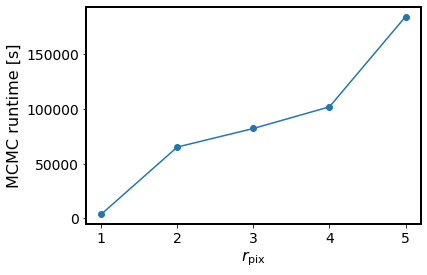

In [11]:
import datetime
r_pix_list = [1, 2, 3, 4, 5]
runtime_list = ['0-01:02:41', '0-18:07:12', '0-22:50:13', '1-04:19:52', '2-03:13:53']
#print(runtime_list[0].split('-')[1].split(':')[0])
#raise
#runtime_list = ['01:02:41', '18:07:12', '22:50:13', '28:19:52', '51:13:53']
runtime_list = [datetime.timedelta(days=int(r.split('-')[0]), 
                                   hours=int(r.split('-')[1].split(':')[0]), 
                                   minutes=int(r.split('-')[1].split(':')[1]), 
                                   seconds=int(r.split('-')[1].split(':')[2])) for r in runtime_list]
seconds_list = [r.total_seconds() for r in runtime_list]

plt.plot(r_pix_list, seconds_list, marker='o')
plt.xlabel(r"$r_{\rm pix}$", fontsize=16)
plt.ylabel("MCMC runtime [s]", fontsize=16)
plt.show()